## Portfolio optimization using Genetic Algorithm

### Background : 
   
   **Portfolio optimization** is one of the most interesting fields of study of financial mathematics. Since the birth of Modern Portfolio Theory (MPT) by Harry Markowitz, many scientists have studied a lot of analytical and numerical methods to build the best investment portfolio according to a defined set of assets. The power of genetic algorithms makes it possible to find the optimal portfolio.
In dealing with this Optimization problem, Harry Markowitz 1959 developed a quantitative model, also called **mean-variance model**. The mean-variance model has been usually considered as either the minimization of an objective function representing the portfolio variance (risk) for a given level of return or the maximization of an objective function representing the portfolio return for a given level of risk.


### Problem Statement: 
   Let’s say we have selected N financial assets we want to invest in. They can be stock, funds, bonds, ETF etc. Each one of them has many historical returns, that is the price relative difference from one period to another. Periods can be days, weeks, months and so on. Build an investment portfolio with a  mix of many assets (They can be stock, funds, bonds, ETF) together allocating a fraction x of total  capital to each one of them. Each fraction is called weight.  The goal of portfolio optimization is to find the values of the weights that Maximize returns and minimize risk simultaneously of our portfolio under some constraints. 

#### Given Data:
Monthly Closing Stock values of HDFC, ITC, L&T, M&M, Sun Pharma and TCS from June 2015 to June 2018.

### Approach and Tasks:

1. Read the data and combine them into one dataframe.
2. Calculate the historical returns for 3 months, 6 months, 12 months, 24 months and 36 months for each of the stocks.
3. Define **Gene** (Scalar): A fraction of the total capital assigned to a stock.
4. Define **Chromosome** (1D Array): Set of genes i.e. fractions of total capital assigned to each stock. Sum of each chromosome should be equal to 1.
5. Generate **Initial Population** (2D Array): A set of randomly generated chromosomes.
6. **Fitness function** (Define a Function): 

The **Sharpe ratio**, S, is a measure for quantifying the performance (Fitness) of the portfolio which works on "Maximisation of return (mean) and minimisation of risk (Variance) simultaneously" and is computed as
follows:
                
                S = (µ − r)/σ
    
    Here µ is the return of the portfolio over a specified period or Mean portfolio return, 
         r is the risk-free rate over the same period and 
         σ is the standard deviation of the returns over the specified period or Standard deviation of portfolio return.

      
    Mean portfolio return = Mean Return * Fractions of Total Capital (Chromosome).
    Risk-free rate = 0.0697 ( as per google)
    Standard deviation of portfolio return = (chromosome * Standard deviation)**2 + Covariance * Respective weights in chromosome.
    
7. Select **Elite Population** (Define a Function): It filters the elite chromosomes which have highest returns, which was calculated in fitness function.
    
8. **Mutation**: A function that will perform mutation in a chromosome. Randomly we shall choose 2 numbers between 0, 5 and those elements we shall swap.

9. Crossover: **Heuristic crossover** or **Blend Crossover** uses the ﬁtness values of two parent chromosomes to ascertain the direction of the search. It moves from worst parent to best parent. 
The oﬀspring are created according to the equation:
            Off_spring A = Best Parent  + β ∗ ( Best Parent − Worst Parent)
            Off_spring B = Worst Parent - β ∗ ( Best Parent − Worst Parent)
                Where β is a random number between 0 and 1.
This crossover type is good for real-valued genomes.

10. **Next Generation** (define a Function): A function which does mutation,mating or crossover based on a probability and builds a new generation of chromosomes.
    
11. **Iterate the process**: Iterate the whole process till their is no change in maximum returns or for fixed number of iterations. 

#### Pre-requisite tasks:

In [1]:
import numpy as np
import pandas as pd
from functools import reduce

1.
#### Read the data and combine them into one dataframe.

In [2]:
files=['hdfc.csv','itc.csv','l&t.csv','m&m.csv','sunpha.csv','tcs.csv']
dfs=[]

for file in files:
    temp=pd.read_csv(file)
    temp.columns=['Date',file.replace('.csv','')]
    dfs.append(temp)

stocks = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
print(stocks.shape)
stocks.head()

(37, 7)


,Date,hdfc,itc,l&t,m&m,sunpha,tcs
0,June 2018,2108.05,266.05,1271.3,896.80,560.55,1847.20
1,May 2018,2136.15,271.60,1367.6,923.50,480.15,1744.80
2,Apr 2018,1944.60,281.45,1400.6,872.65,528.15,1765.70
3,Mar 2018,1891.45,255.90,1311.9,740.20,495.40,1424.65
4,Feb 2018,1883.80,265.10,1319.1,728.75,535.35,1519.13


2.
#### Calculate the historical returns for 3 months, 6 months, 12 months, 24 months and 36 months for each of the stock.

**Stock Return**:
The formula for the total stock return is the appreciation in the price plus any dividends paid, divided by the original price of the stock.


In [3]:
def hist_return(months):
    ''' It calculates Stock returns for various months and returns a dataframe.
        Input: Months in the form of a list.
        Output: Historical returns in the form of a DataFrame. '''
    idx=[]
    df=pd.DataFrame()
    for mon in months:
        temp=(stocks.iloc[0,1:] - stocks.iloc[mon,1:])/(stocks.iloc[mon,1:])
        idx.append(str(mon)+'_mon_return')
        df=pd.concat([df, temp.to_frame().T], ignore_index=True)
    df.index=idx
    return df    

In [4]:
hist_stock_returns=hist_return([3,6,12,24,36])
hist_stock_returns

,hdfc,itc,l&t,m&m,sunpha,tcs
3_mon_return,0.114515,0.039664,-0.030947,0.211564,0.13151,0.296599
6_mon_return,0.125163,0.011212,0.011417,0.194062,-0.017957,0.368094
12_mon_return,0.275866,-0.178478,0.129783,0.330899,0.010911,0.562537
24_mon_return,0.792712,0.084237,0.274461,0.255179,-0.265911,0.44833
36_mon_return,0.974847,0.266844,0.069614,0.399938,-0.358785,0.447535


3.
Define **Gene** (Scalar): A fraction of the total capital assigned to a stock. Lets address them as weights.

    Gene can be a fractional value between 0 to 1, such as 0.32 of HDFC or 0.21 of ITC or 0.56 of TCS.

In [5]:
gene = np.random.rand()
gene

0.752648628613602

In [6]:
import time
def gen_mc_grid(rows, cols, n, N):  # , xfname): generate monte carlo wind farm layout grids
        np.random.seed(seed=int(time.time()))  # init random seed
        layouts = np.zeros((n, rows * cols), dtype=np.int32)  # one row is a layout
        # layouts_cr = np.zeros((n*, 2), dtype=np.float32)  # layouts column row index
        positionX = np.random.randint(0, cols, size=(N * n * 2))
        positionY = np.random.randint(0, rows, size=(N * n * 2))
        ind_rows = 0  # index of layouts from 0 to n-1
        ind_pos = 0  # index of positionX, positionY from 0 to N*n*2-1
        # ind_crs = 0
        while ind_rows < n:
            layouts[ind_rows, positionX[ind_pos] + positionY[ind_pos] * cols] = 1
            if np.sum(layouts[ind_rows, :]) == N:
                # for ind in range(rows * cols):
                #     if layouts[ind_rows, ind] == 1:
                #         r_i = np.floor(ind / cols)
                #         c_i = np.floor(ind - r_i * cols)
                #         layouts_cr[ind_crs, 0] = c_i
                #         layouts_cr[ind_crs, 1] = r_i
                #         ind_crs += 1
                ind_rows += 1
            ind_pos += 1
            if ind_pos >= N * n * 2:
                print("Not enough positions")
                break
        # filename = "positions{}by{}by{}N{}.dat".format(rows, cols, n, N)
#         np.savetxt(lofname, layouts, fmt='%d', delimiter="  ")
        # np.savetxt(xfname, layouts_cr, fmt='%d', delimiter="  ")
        return layouts

def gen_mc_grid_with_NA_loc(rows, cols, n, N,NA_loc):  # , xfname): generate monte carlo wind farm layout grids
        np.random.seed(seed=int(time.time()))  # init random seed
        layouts = np.zeros((n, rows * cols), dtype=np.int32)  # one row is a layout, NA loc is 0

        layouts_NA= np.zeros((n, rows * cols), dtype=np.int32)  # one row is a layout, NA loc is 2
        for i in NA_loc:
            layouts_NA[:,i-1]=2

        # layouts_cr = np.zeros((n*, 2), dtype=np.float32)  # layouts column row index
        positionX = np.random.randint(0, cols, size=(N * n * 2))
        positionY = np.random.randint(0, rows, size=(N * n * 2))
        ind_rows = 0  # index of layouts from 0 to n-1
        ind_pos = 0  # index of positionX, positionY from 0 to N*n*2-1
        # ind_crs = 0
        N_count=0
        while ind_rows < n:
            cur_state=layouts_NA[ind_rows, positionX[ind_pos] + positionY[ind_pos] * cols]
            if cur_state!=1 and cur_state!=2:
                layouts[ind_rows, positionX[ind_pos] + positionY[ind_pos] * cols]=1
                layouts_NA[ind_rows, positionX[ind_pos] + positionY[ind_pos] * cols] = 1
                N_count+=1
                if np.sum(layouts[ind_rows, :]) == N:
                    ind_rows += 1
                    N_count=0
            ind_pos += 1
            if ind_pos >= N * n * 2:
                print("Not enough positions")
                break
        # filename = "positions{}by{}by{}N{}.dat".format(rows, cols, n, N)
#         np.savetxt(lofname, layouts, fmt='%d', delimiter="  ")
#         np.savetxt(loNAfname, layouts_NA, fmt='%d', delimiter="  ")
        # np.savetxt(xfname, layouts_cr, fmt='%d', delimiter="  ")
        return layouts,layouts_NA

In [7]:
gen_mc_grid(5, 5, 100, 50)
gen_mc_grid_with_NA_loc(5, 5, 100, 50,range(10))

Not enough positions
Not enough positions


(array([[0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[2, 2, 2, ..., 1, 1, 2],
        [2, 2, 2, ..., 0, 0, 2],
        [2, 2, 2, ..., 0, 0, 2],
        ...,
        [2, 2, 2, ..., 0, 0, 2],
        [2, 2, 2, ..., 0, 0, 2],
        [2, 2, 2, ..., 0, 0, 2]]))

4.
Define **Chromosome** (1D Array): Set of genes i.e. fractions of total capital assigned to each stock. Set of weights.

Its a 1d Array of the fractional values of all the stocks such that sum of the array will not be over 1. 
As we have 6 company stocks, we shall generate 6 fractional values (genes) which constitues 1 chromosome.
    
**Why sum should be equal to 1?** As these are fraction of the total capital, we are assuming total capital to be 1 unit.
    
**How to make sure sum =1?** Just generate 6 random numbers and then calculate a factor which is 1 / [sum of random numbers]. Finally multiply each of the random numbers with that factor. The sum will be 1.

In [8]:
def chromosome(n):
    ''' Generates set of random numbers whose sum is equal to 1
        Input: Number of stocks.
        Output: Array of random numbers'''
    ch = np.random.rand(n)
    return ch/sum(ch)

In [9]:
child=chromosome(6)
print(child,sum(child))

[0.27169764 0.08931079 0.22830943 0.12181337 0.06624758 0.22262119] 1.0


5.
Generate **Initial Population** (2D Array): A set of randomly generated chromosomes

In [10]:
n=6 # Number of stocks = 6
pop_size=100 # initial population = 100

population = np.array([chromosome(n) for _ in range(pop_size)])
print(population.shape)
print(population)

(100, 6)
[[8.03938323e-02 8.08089514e-02 1.76670004e-01 2.28088105e-01
  2.16426185e-01 2.17612922e-01]
 [2.56212908e-01 5.47140581e-02 2.08186952e-01 1.37773711e-01
  6.04249267e-02 2.82687445e-01]
 [1.88366306e-01 5.34607029e-02 1.35293992e-01 2.25366974e-01
  2.17252833e-01 1.80259192e-01]
 [2.60955192e-01 2.38861994e-01 5.14484239e-02 1.90381052e-01
  1.09711083e-01 1.48642254e-01]
 [2.11712769e-01 8.31695151e-02 1.66725301e-01 4.48516173e-02
  2.21372021e-01 2.72168776e-01]
 [4.06504941e-01 6.82338843e-03 7.71878945e-02 4.14852865e-02
  3.78145202e-01 8.98532874e-02]
 [9.16181377e-02 2.87859731e-01 1.19184084e-01 1.59279152e-01
  2.60774901e-01 8.12839953e-02]
 [3.87703814e-01 1.96208664e-01 1.31186276e-01 1.21441747e-01
  2.82915892e-02 1.35167910e-01]
 [3.68047143e-02 3.59589355e-01 3.82187845e-01 4.66582604e-02
  1.60912608e-01 1.38472180e-02]
 [9.66609238e-02 9.23617379e-02 2.84278931e-01 1.82109795e-01
  8.41650042e-02 2.60423608e-01]
 [1.51896658e-01 2.09513427e-01 1.7347673

6.
**Fitness function** (Define a Function): 
The Sharpe ratio, S, is a measure for quantifying the performance (Fitness) of the portfolio and is computed as
follows:
                
                S = (µ − r)/σ
    
    Here µ is the return of the portfolio over a specified period or Mean portfolio return, 
         r is the risk-free rate over the same period and 
         σ is the standard deviation of the returns over the specified period or Standard deviation of portfolio return.

      
Mean portfolio return = Mean Return * Fractions of Total Capital (Chromosome).

Risk-free rate = 0.0697 ( as per google)

Standard deviation of portfolio return = (chromosome * Standard deviation)**2 + Covariance * Respective weights in chromosome.

 #### Fitness function Task 1:
 Calculate Mean, Standard deviation and covariance of the Historical stock returns.

In [11]:
# Convert to numeric columns from Object datatypes.
print(hist_stock_returns.info())
cols=hist_stock_returns.columns
hist_stock_returns[cols] = hist_stock_returns[cols].apply(pd.to_numeric, errors='coerce')
print(hist_stock_returns.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 3_mon_return to 36_mon_return
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hdfc    5 non-null      object
 1   itc     5 non-null      object
 2   l&t     5 non-null      object
 3   m&m     5 non-null      object
 4   sunpha  5 non-null      object
 5   tcs     5 non-null      object
dtypes: object(6)
memory usage: 280.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 3_mon_return to 36_mon_return
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hdfc    5 non-null      float64
 1   itc     5 non-null      float64
 2   l&t     5 non-null      float64
 3   m&m     5 non-null      float64
 4   sunpha  5 non-null      float64
 5   tcs     5 non-null      float64
dtypes: float64(6)
memory usage: 280.0+ bytes
None


#### Calculate covariance of historical returns

In [12]:
cov_hist_return=hist_stock_returns.cov()

print(cov_hist_return)

# For ease of calculations make covariance of same variable as zero.
for i in range(6):
    cov_hist_return.iloc[i][i]=0
    
cov_hist_return

            hdfc       itc       l&t       m&m    sunpha       tcs
hdfc    0.160272  0.045393  0.027916  0.024127 -0.079078  0.014362
itc     0.045393  0.025467 -0.000718  0.004381 -0.023178 -0.005554
l&t     0.027916 -0.000718  0.014206  0.002510 -0.013841  0.007330
m&m     0.024127  0.004381  0.002510  0.007412 -0.011042  0.005700
sunpha -0.079078 -0.023178 -0.013841 -0.011042  0.041781 -0.007211
tcs     0.014362 -0.005554  0.007330  0.005700 -0.007211  0.009923


,hdfc,itc,l&t,m&m,sunpha,tcs
hdfc,0.000000,0.045393,0.027916,0.024127,-0.079078,0.014362
itc,0.045393,0.000000,-0.000718,0.004381,-0.023178,-0.005554
l&t,0.027916,-0.000718,0.000000,0.002510,-0.013841,0.007330
m&m,0.024127,0.004381,0.002510,0.000000,-0.011042,0.005700
sunpha,-0.079078,-0.023178,-0.013841,-0.011042,0.000000,-0.007211
tcs,0.014362,-0.005554,0.007330,0.005700,-0.007211,0.000000


#### Calculate the mean of historical returns

In [13]:
mean_hist_return=hist_stock_returns.mean()
mean_hist_return

hdfc      0.456621
itc       0.044696
l&t       0.090865
m&m       0.278328
sunpha   -0.100047
tcs       0.424619
dtype: float64

#### Calculate Standard deviation of historical returns:

In [14]:
sd_hist_return=hist_stock_returns.std()
sd_hist_return

hdfc      0.400340
itc       0.159583
l&t       0.119189
m&m       0.086091
sunpha    0.204405
tcs       0.099615
dtype: float64

#### Fitness function:
 Calculate Expected portfolio return and portfolio variance.

#### Calculate Expected returns of portfolio.

In [15]:
def mean_portfolio_return(child):
    return np.sum(np.multiply(child,mean_hist_return))

In [16]:
mean_portfolio_return(population[0])

0.19060776152121672

#### Calculate portfolio variance.

In [17]:
def var_portfolio_return(child):
    part_1 = np.sum(np.multiply(child,sd_hist_return)**2)
    temp_lst=[]
    for i in range(6):
        for j in range(6):
            temp=cov_hist_return.iloc[i][j] * child[i] * child[j]
            temp_lst.append(temp)
    part_2=np.sum(temp_lst)
    return part_1+part_2

In [18]:
var_portfolio_return(population[0])

0.002115202931568862

#### Risk free factor.

In [19]:
rf= 0.0697

#### Fitness Function of a portfolio.

In [20]:
def fitness_fuction(child):
    ''' This will return the Sharpe ratio for a particular portfolio.
        Input: A child/chromosome (1D Array)
        Output: Sharpe Ratio value (Scalar)'''
    return (mean_portfolio_return(child)-rf)/np.sqrt(var_portfolio_return(child))

In [21]:
fitness_fuction(population[7])

1.1197938432017773

7.
Select **Elite Population** (Define a Function): It filters the elite chromosomes which have highest returns, which were calculated in fitness function.

In [22]:
def Select_elite_population(population, frac=0.3):
    ''' Select elite population from the total population based on fitness function values.
        Input: Population and fraction of population to be considered as elite.
        Output: Elite population.'''
    population = sorted(population,key = lambda x: fitness_fuction(x),reverse=True)
    percentage_elite_idx = int(np.floor(len(population)* frac))
    return population[:percentage_elite_idx]

In [23]:
print(len(Select_elite_population(population, frac=0.3)))
Select_elite_population(population, frac=0.3)

30


[array([0.03823345, 0.14512891, 0.12858713, 0.14459243, 0.25871207,
        0.28474601]),
 array([0.01550867, 0.01472772, 0.09150112, 0.49860786, 0.14784215,
        0.23181247]),
 array([0.04270952, 0.12964518, 0.21063279, 0.1317937 , 0.23115753,
        0.25406129]),
 array([0.03620596, 0.3516264 , 0.06084279, 0.02256249, 0.15567839,
        0.37308396]),
 array([0.08039383, 0.08080895, 0.17667   , 0.22808811, 0.21642619,
        0.21761292]),
 array([0.03691811, 0.09236852, 0.22640331, 0.22767887, 0.20424601,
        0.21238517]),
 array([0.0008036 , 0.17245699, 0.25847572, 0.17888153, 0.17285265,
        0.2165295 ]),
 array([0.03110176, 0.16660845, 0.20616284, 0.21580393, 0.25179411,
        0.12852892]),
 array([0.07449338, 0.00040479, 0.15767907, 0.30271208, 0.31849886,
        0.14621181]),
 array([0.00953699, 0.29353459, 0.22692254, 0.02106576, 0.1837813 ,
        0.26515883]),
 array([0.02981767, 0.22767208, 0.23732672, 0.07591864, 0.13903345,
        0.29023144]),
 array([0.

In [24]:
[fitness_fuction(x) for x in population][:3]

[2.6289247850362423, 1.6344035730344217, 1.9949936772519008]

8.**Mutation**: A function that will perform mutation in a chromosome. 
            
    Randomly choose 2 numbers between [0, 5] and those elements should be swapped.


In [25]:
def mutation(parent):
    ''' Randomy choosen elements of a chromosome are swapped
        Input: Parent
        Output: Offspring (1D Array)'''
    child=parent.copy()
    n=np.random.choice(range(6),2)
    while (n[0]==n[1]):
        n=np.random.choice(range(6),2)
    child[n[0]],child[n[1]]=child[n[1]],child[n[0]]
    return child

In [26]:
mutation(population[1]),population[1]

(array([0.25621291, 0.05471406, 0.20818695, 0.13777371, 0.28268745,
        0.06042493]),
 array([0.25621291, 0.05471406, 0.20818695, 0.13777371, 0.06042493,
        0.28268745]))

9. 
Crossover: **Heuristic crossover** or **Blend Crossover** uses the ﬁtness values of two parent chromosomes to ascertain the direction of the search. It moves from worst parent to best parent. 

The oﬀspring are created according to the equation:
            
            Off_spring A = Best Parent  + β ∗ ( Best Parent − Worst Parent)
            Off_spring B = Worst Parent - β ∗ ( Best Parent − Worst Parent)
                Where β is a random number between 0 and 1.
This crossover type is good for real-valued genomes.

In [27]:
def Heuristic_crossover(parent1,parent2):
    ''' The oﬀsprings are created according to the equation:
            Off_spring A = Best Parent  + β ∗ ( Best Parent − Worst Parent)
            Off_spring B = Worst Parent - β ∗ ( Best Parent − Worst Parent)
                Where β is a random number between 0 and 1.
        Input: 2 Parents
        Output: 2 Children (1d Array)'''
    ff1=fitness_fuction(parent1)
    ff2=fitness_fuction(parent2)
    diff=parent1 - parent2
    beta=np.random.rand()
    if ff1>ff2:
        child1=parent1 + beta * diff
        child2=parent2 - beta * diff
    else:
        child2=parent1 + beta * diff
        child1=parent2 - beta * diff
    return child1,child2

In [28]:
def Arithmetic_crossover(parent1,parent2):
    ''' The oﬀsprings are created according to the equation:
            Off spring A = α ∗ Parent1 + (1 −α) ∗ Parent2
            Off spring B = (1 −α) ∗ Parent1 + α ∗ Parent2
            
                Where α is a random number between 0 and 1.
        Input: 2 Parents
        Output: 2 Children (1d Array)'''
    alpha = np.random.rand()
    child1 = alpha * parent1 + (1-alpha) * parent2
    child2 = (1-alpha) * parent1 + alpha * parent2
    return child1,child2

In [29]:
Arithmetic_crossover(population[2],population[3])

(array([0.25298445, 0.21850371, 0.06065522, 0.19422274, 0.12151988,
        0.152114  ]),
 array([0.19633705, 0.07381899, 0.12608719, 0.22152529, 0.20544404,
        0.17678744]))

In [30]:
for i in population[:30]:
    for j in population[:30]:
        print(Arithmetic_crossover(i,j))

(array([0.08039383, 0.08080895, 0.17667   , 0.22808811, 0.21642619,
       0.21761292]), array([0.08039383, 0.08080895, 0.17667   , 0.22808811, 0.21642619,
       0.21761292]))
(array([0.19137883, 0.06433667, 0.19656494, 0.17107755, 0.11795109,
       0.25869092]), array([0.14522791, 0.07118634, 0.18829202, 0.19478427, 0.15890002,
       0.24160945]))
(array([0.12661362, 0.06910198, 0.15895817, 0.22692327, 0.21678005,
       0.20162291]), array([0.14214652, 0.06516767, 0.15300583, 0.22653181, 0.21689897,
       0.19624921]))
(array([0.17294948, 0.16182685, 0.1124815 , 0.20875949, 0.16172409,
       0.1822586 ]), array([0.16839955, 0.1578441 , 0.11563693, 0.20970966, 0.16441318,
       0.18399658]))
(array([0.16214252, 0.08227845, 0.17047923, 0.1140197 , 0.21950507,
       0.25157504]), array([0.12996409, 0.08170002, 0.17291608, 0.15892002, 0.21829314,
       0.23820666]))
(array([0.35263603, 0.01904475, 0.09362092, 0.07230942, 0.35143152,
       0.11095736]), array([0.13426275, 0.06858

       0.11498283]))
(array([0.03743204, 0.35024177, 0.06265881, 0.02709423, 0.15380616,
       0.36876699]), array([0.07147254, 0.3117991 , 0.11307832, 0.15291215, 0.10182604,
       0.24891185]))
(array([0.07304089, 0.25129311, 0.12305374, 0.18514771, 0.14163212,
       0.22583243]), array([0.07415111, 0.05952615, 0.14951968, 0.27500826, 0.27682055,
       0.16497426]))
(array([0.06959976, 0.40399537, 0.1776959 , 0.11448982, 0.16659335,
       0.0676258 ]), array([0.07176444, 0.3386251 , 0.13382632, 0.14449508, 0.12004278,
       0.19124628]))
(array([0.17143656, 0.31700947, 0.06790611, 0.03956703, 0.16313813,
       0.2409427 ]), array([0.07647189, 0.31066649, 0.11309868, 0.15293922, 0.1023684 ,
       0.24445532]))
(array([0.14920054, 0.20941775, 0.09904594, 0.20976665, 0.06212276,
       0.27044635]), array([0.19157776, 0.15347199, 0.09026693, 0.23875014, 0.04116677,
       0.28476642]))
(array([0.10084124, 0.12484358, 0.186971  , 0.12536954, 0.2128226 ,
       0.24915203]), array


10.**Next Generation**: A function which does mutation,mating or crossover based on a probability and builds a new generation of chromosomes.

In [31]:
def next_generation(pop_size,elite,crossover=Heuristic_crossover):
    ''' Generates new population from elite population with mutation probability as 0.4 and crossover as 0.6. 
        Over the final stages, mutation probability is decreased to 0.1.
        Input: Population Size and elite population.
        Output: Next generation population (2D Array).'''
    new_population=[]
    elite_range=range(len(elite))
#     print(elite_range)
    while len(new_population) < pop_size:
        if len(new_population) > 2*pop_size/3: # In the final stages mutation frequency is decreased.
            mutate_or_crossover = np.random.choice([0, 1], p=[0.9, 0.1])
        else:
            mutate_or_crossover = np.random.choice([0, 1], p=[0.4, 0.6])
#         print(mutate_or_crossover)
        if mutate_or_crossover:
            indx=np.random.choice(elite_range)
            new_population.append(mutation(elite[indx]))
        else:
            p1_idx,p2_idx=np.random.choice(elite_range,2)
            c1,c2=crossover(elite[p1_idx],elite[p2_idx])
            chk=0
            for gene in range(6):
                if c1[gene]<0:
                    chk+=1
                else:
                    chk+=0
            if sum(range(chk))>0:
                p1_idx,p2_idx=np.random.choice(elite_range,2)
                c1,c2=crossover(elite[p1_idx],elite[p2_idx])
            new_population.extend([c1,c2])
    return new_population

In [32]:
elite=Select_elite_population(population)
next_generation(100,elite)[:3]

[array([0.05718409, 0.18300236, 0.15358693, 0.17147762, 0.13988888,
        0.29486012]),
 array([ 0.21253109, -0.04585185,  0.18528815,  0.19342244,  0.1940922 ,
         0.26051796]),
 array([0.07140975, 0.29828364, 0.09164993, 0.13843801, 0.12983598,
        0.27038269])]

In [33]:
elite=Select_elite_population(population)
next_generation(100,elite,Arithmetic_crossover)[:3]

[array([0.15659154, 0.1986943 , 0.19560888, 0.14094565, 0.21886732,
        0.0892923 ]),
 array([0.12155986, 0.15151898, 0.16069828, 0.18891797, 0.10624282,
        0.27106208]),
 array([0.09872285, 0.11229233, 0.16955865, 0.21064775, 0.16736746,
        0.24141096])]

11. **Iterate the process**: Iterate the whole process till their is no change in maximum returns/min risk or for fixed number of iterations. 

#### With Heuristic_crossover:

In [34]:
n=6 # Number of stocks = 6
pop_size=100 # initial population = 100

# Initial population
population = np.array([chromosome(n) for _ in range(pop_size)])

# Get initial elite population
elite = Select_elite_population(population)

iteration=0 
Expected_returns=0
Expected_risk=1

while (Expected_returns < 0.30 and Expected_risk > 0.0005) or iteration <= 40:
    print('Iteration:',iteration)
    population = next_generation(100,elite)
    elite = Select_elite_population(population)
    Expected_returns=mean_portfolio_return(elite[0])
    Expected_risk=var_portfolio_return(elite[0])
    print('Expected returns of {} with risk of {}\n'.format(Expected_returns,Expected_risk))
    iteration+=1


print('Portfolio of stocks after all the iterations:\n')
[print(hist_stock_returns.columns[i],':',elite[0][i]) for i in list(range(6))]

Iteration: 0
Expected returns of 0.1710501854379138 with risk of 0.000710548599364709

Iteration: 1
Expected returns of 0.15534899338211983 with risk of 0.00047762004006212744

Iteration: 2
Expected returns of 0.2665750623194529 with risk of 0.0022929391497681167

Iteration: 3
Expected returns of 0.17659530797496312 with risk of 0.000657023113340067

Iteration: 4
Expected returns of 0.16645454910321153 with risk of 0.0005052793555819154

Iteration: 5
Expected returns of 0.1757978129921396 with risk of 0.0006002924690672413

Iteration: 6
Expected returns of 0.12051804139710282 with risk of 0.00012184784167732204

Iteration: 7
Expected returns of 0.10944890365914346 with risk of 5.7919004011922764e-05

Iteration: 8
Expected returns of 0.13761087192639768 with risk of 0.00014625162584999164

Iteration: 9
Expected returns of 0.13411104436975732 with risk of 0.00014724679400939314

Iteration: 10
Expected returns of 0.14135233534697442 with risk of 0.00018639823497096537

Iteration: 11
Expec

[None, None, None, None, None, None]

### Weights and their respective returns:

In [35]:
print('Portfolio of stocks after all the iterations:\n')
[print(hist_stock_returns.columns[i],':',elite[0][i]) for i in list(range(6))]

print('\nExpected returns of {} with risk of {}\n'.format(Expected_returns,Expected_risk))

Portfolio of stocks after all the iterations:

hdfc : -0.16640230936011627
itc : 0.432171304453574
l&t : 0.24996993971353434
m&m : 0.046598689025655636
sunpha : 0.07299053973884723
tcs : 0.36467183642850576

Expected returns of 0.1265610566267609 with risk of 2.5786210805216897e-05



Although heuristic method works well, it gives negative returns which is not expected.

In [36]:
fitness_fuction(elite[5])

7.238633688416429

## BEST Approach using Arithmetic_crossover:

In [41]:
n=6 # Number of stocks = 6
pop_size=100 # initial population = 100

# Initial population
population = np.array([chromosome(n) for _ in range(pop_size)])

# Get initial elite population
elite = Select_elite_population(population)

iteration=0 
Expected_returns=0
Expected_risk=1

while ((Expected_returns < 0.30 and Expected_risk > 0.0005) or iteration <= 40):
    print('Iteration:',iteration)
    population = next_generation(100,elite,Arithmetic_crossover)
    elite = Select_elite_population(population)
    Expected_returns=mean_portfolio_return(elite[0])
    Expected_risk=var_portfolio_return(elite[0])
    print('Expected returns of {} with risk of {}\n'.format(Expected_returns,Expected_risk))
    iteration+=1
    if(iteration>100):
        break


print('Portfolio of stocks after all the iterations:\n')
[print(hist_stock_returns.columns[i],':',elite[0][i]) for i in list(range(6))]

Iteration: 0
Expected returns of 0.14063845599820804 with risk of 0.0004047255286635668

Iteration: 1
Expected returns of 0.2008751533154483 with risk of 0.0012981374332054528

Iteration: 2
Expected returns of 0.1600245015506915 with risk of 0.0006079135957966515

Iteration: 3
Expected returns of 0.16378014203096547 with risk of 0.0006333285634314637

Iteration: 4
Expected returns of 0.15706929561346927 with risk of 0.0005314291864681507

Iteration: 5
Expected returns of 0.1923361290507939 with risk of 0.0010304423850078003

Iteration: 6
Expected returns of 0.1912432432206128 with risk of 0.0010190337858013636

Iteration: 7
Expected returns of 0.18988954696689617 with risk of 0.0009999994475996575

Iteration: 8
Expected returns of 0.18731448659072714 with risk of 0.0009688724063605402

Iteration: 9
Expected returns of 0.18731080639525582 with risk of 0.0009688510838831953

Iteration: 10
Expected returns of 0.16163344212199982 with risk of 0.0005711182562638719

Iteration: 11
Expected r

Expected returns of 0.16320102729146738 with risk of 0.0005860629900714155

Iteration: 93
Expected returns of 0.16320102729146738 with risk of 0.0005860629900714155

Iteration: 94
Expected returns of 0.163201027291473 with risk of 0.0005860629900714858

Iteration: 95
Expected returns of 0.16320102729147531 with risk of 0.0005860629900715144

Iteration: 96
Expected returns of 0.16320102729147018 with risk of 0.0005860629900714511

Iteration: 97
Expected returns of 0.1632010272914764 with risk of 0.0005860629900715291

Iteration: 98
Expected returns of 0.16320102729147487 with risk of 0.0005860629900715092

Iteration: 99
Expected returns of 0.16320102729147543 with risk of 0.0005860629900715161

Iteration: 100
Expected returns of 0.1632010272914735 with risk of 0.0005860629900714927

Portfolio of stocks after all the iterations:

hdfc : 0.048332529678546884
itc : 0.1774417460990843
l&t : 0.09389664007556012
m&m : 0.14254256185553388
sunpha : 0.27323974112410576
tcs : 0.26454678116716923


[None, None, None, None, None, None]

In [42]:
print('Portfolio of stocks after all the iterations:\n')
[print(hist_stock_returns.columns[i],':',elite[0][i]) for i in list(range(6))]

print('\nExpected returns of {} with risk of {}\n'.format(Expected_returns,Expected_risk))

Portfolio of stocks after all the iterations:

hdfc : 0.048332529678546884
itc : 0.1774417460990843
l&t : 0.09389664007556012
m&m : 0.14254256185553388
sunpha : 0.27323974112410576
tcs : 0.26454678116716923

Expected returns of 0.1632010272914735 with risk of 0.0005860629900714927



### Comparision with MPT:

In [43]:
covariance = cov_hist_return.to_numpy()
covariance

array([[ 0.        ,  0.04539296,  0.02791593,  0.02412731, -0.07907816,
         0.01436192],
       [ 0.04539296,  0.        , -0.00071845,  0.00438124, -0.02317835,
        -0.0055536 ],
       [ 0.02791593, -0.00071845,  0.        ,  0.00250974, -0.0138409 ,
         0.00732976],
       [ 0.02412731,  0.00438124,  0.00250974,  0.        , -0.01104228,
         0.00569969],
       [-0.07907816, -0.02317835, -0.0138409 , -0.01104228,  0.        ,
        -0.00721078],
       [ 0.01436192, -0.0055536 ,  0.00732976,  0.00569969, -0.00721078,
         0.        ]])

Portfolio Expected Return: 8.166666666666666


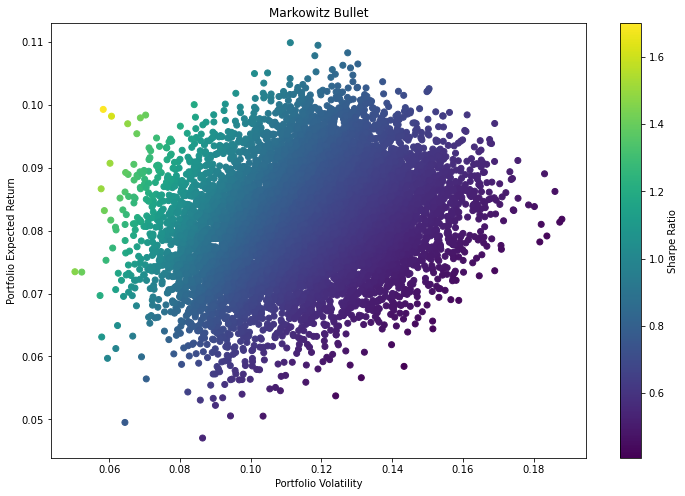

In [44]:
import matplotlib.pyplot as plt

expected_returns = np.array([0.12, 0.09, 0.03, 0.11, 0.05, 0.09]) ### random returns
portfolio_weights = np.ones(len(expected_returns))/len(expected_returns)
portfolio_return = np.dot(expected_returns, portfolio_weights)
portfolio_variance = np.dot(np.dot(portfolio_weights, covariance), portfolio_weights)

print("Portfolio Expected Return:", portfolio_return*100)

num_portfolios = 10000
portfolio_returns = np.zeros(num_portfolios)
portfolio_variances = np.zeros(num_portfolios)

for i in range(num_portfolios):
    weights = np.random.random(len(expected_returns))
    weights /= np.sum(weights)
    
    portfolio_returns[i] = np.dot(expected_returns, weights)
    portfolio_variances[i] = np.sqrt(np.dot(np.dot((weights), abs(covariance)), (weights)))
    
plt.figure(figsize=(12,8))
plt.scatter(portfolio_variances, portfolio_returns, c=portfolio_returns/portfolio_variances)
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Markowitz Bullet')
plt.show()

#### References:
1. https://www.researchgate.net/publication/286952225_A_heuristic_crossover_for_portfolio_selection
2. https://pdfs.semanticscholar.org/9888/061ea3326ff9b41c807ed21f0c10463b7879.pdf
3. https://www.math.kth.se/matstat/seminarier/reports/M-exjobb12/121008.pdf
